# Interpolation and regression

Requirements for this notebook:
* python
* jupyter
* numpy
* scipy
* random
* matplotlib
* scikit-learn


In [5]:
import random
from matplotlib import pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

## Non-parametric models

When people talk about non-parametric models, they really mean models where the number of parameters can grow with the number of data points (i.e. 'infinite parametric' models). We will start with the classic example of interpolation in one-dimension, which is cubic spline, before moving on to Gaussian Process Regression.

### Cubic spline

We will start with a very complex model for the data, that cannot be represented by a simple polynomial.

In [6]:
import math
def model_complex(x_in,params):
    """output a value y for a given input x"""
    n=len(params)
    y = 0.
    for i in range(0,n):
      if math.fmod(i,2) == 0:
        y = y + params[i]*math.sin(float(i)*x_in+params[i+1])
      else:
        y = y

    return y

We once again generate the parameter values randomly, though this model will have 10 input parameters. For the sake of simplicity, this time we will not add any dispersion to the data.

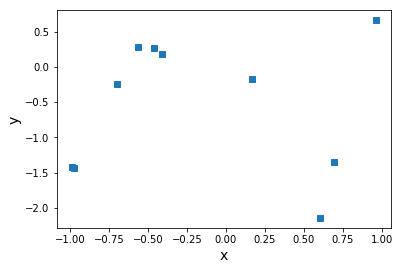

In [7]:
random.seed()

n_params = 10
params = np.zeros(n_params)
for i in range(0,n_params):
    params[i] = random.uniform(-1,1)

n_points=10
x_complex = np.zeros(n_points)
y_complex = np.zeros(n_points)
for i in range(0,n_points):
    x_complex[i] = random.uniform(-1,1)
    y_complex[i] = model_complex(x_complex[i],params)

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
lab_fontsize = 14
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

We see three inflection points (by eye), so we can try fitting this data, with (for example) a fourth-order polynomial, just to see what happens.

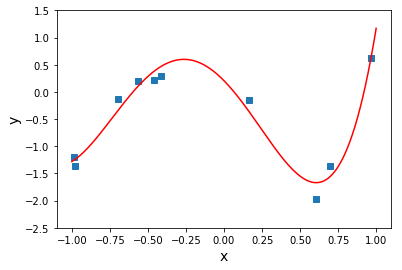

In [21]:
z = np.polyfit(x_complex, y_complex, 4)

p = np.poly1d(z)
x_out_complex=np.arange(-1,1.,0.001)
y_out_complex=[]
for i in range(0,len(x_out_complex)):
    y_out_complex.append(p(x_out_complex[i]))

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
h1 = plt.plot(x_out_complex,y_out_complex,'-r')
plt.ylim([-2.5,1.5])
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

How would it perform if we fitted to a higher-order polynomial? We have 10 data points, so we could increase to the maximum, which is 10.

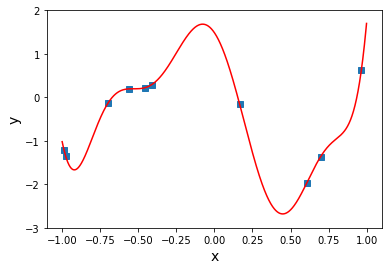

In [23]:
z = np.polyfit(x_complex, y_complex, 10)

p_10 = np.poly1d(z)
y_out_p_10=[]
for i in range(0,len(x_out_complex)):
    y_out_p_10.append(p_10(x_out_complex[i]))

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
h1 = plt.plot(x_out_complex,y_out_p_10,'-r')
plt.ylim([-3,2])
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

Here we get a warning because we are trying to fit 10 parameters with 10 data points. But the curve does pass through all the data points.

Instead, if we really don't care about what model we are using, and are happy for it to increase in dimensionality with the number of data points, we can use [cubic spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) here to interpolate between the data points. 

196 196


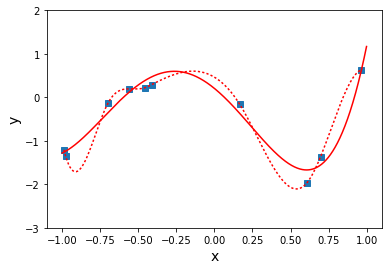

In [25]:
import scipy.interpolate

f = scipy.interpolate.interp1d(x_complex,y_complex,kind='cubic')
y_out_spline =[]
x_out_spline = np.arange(min(x_complex),max(x_complex),0.01)
for i in range(0,len(x_out_spline)):
    y_out_spline.append(f(x_out_spline[i]))

print(len(x_out_spline),len(y_out_spline))
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
h1 = plt.plot(x_out_complex,y_out_complex,'-r')
h2 = plt.plot(x_out_spline,y_out_spline,':r')
plt.ylim([-3,2])
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

This goes through all the data points sucessfully, but isn't very smooth. In fact it gives roughly the same behaviour as the tenth-order polynomial, but isn't quite as oscillatory as the 10th order polynomial.

This disadvantage of cubic spline is that we cannot make a prediction outside of the range given by the range of $x$ values, and there is no common way to propagate any measurment errors we have forward to the predictions between the specific x-values. 

### Gaussian Process Regression

Now we turn to Gaussian Processes in python. We make use of the implementation in the [scikit-learn](http://scikit-learn.org/stable/documentation.html) package.

We start by initialising the type of GP we will be using.

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

kernel = kernels.RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))

gp = GaussianProcessRegressor(kernel=kernel)

Here the kernel describes the covariance function. Here we have picked a Radial Basis Function, with form

\begin{equation}
\rm{cov}(f(x_i),f(x_j))=k(x_i,x_j)=\exp\left(-\frac12|x_i-x_j|^2\right)
\end{equation}

In [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) they refer to this the *squared exponential* covariance function, but it is the same.

In [27]:
xprime = np.atleast_2d(x_complex).T
yprime = np.atleast_2d(y_complex).T
gp.fit(xprime, yprime)
y_pred, sigma = gp.predict(x_out_complex[:, np.newaxis], return_std=True)

The array containing the predicted values for $y$ from the Gaussian Process will be two dimensional, which isn't helpful for us, so we need to [flatten](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html) it.

In [28]:
y_pred = y_pred.flatten()

Now we can plot the prediction from the GP (which is much the same as the cubic spline prediction), with the precited 1-sigma error ranges for $y$.

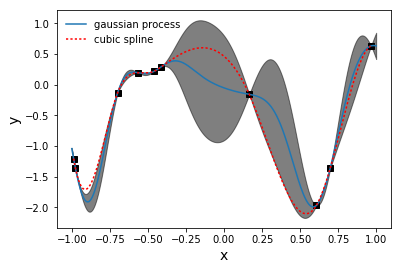

In [29]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s',color='black')
h1 = plt.plot(x_out_complex,y_pred,label='gaussian process')
plt.fill_between(x_out_complex, y_pred - sigma, y_pred + sigma,alpha=0.5, color='k')
h2 = plt.plot(x_out_spline,y_out_spline,':r',label='cubic spline')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=2)

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

#### Choice of kernel

There are a number of different kernels that can be chosen. Scikit-learn has the following implemented

* RBF
\begin{equation}
k_{\rm RBF}(r)=\exp\left(-\frac{r^2}{2\ell^2}\right)
\end{equation}

* Matern

\begin{equation}
k_{\rm{Matern}}(r)=\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}r}{\ell}\right)K_\nu\left(\frac{\sqrt{2\nu}r}{\ell}\right) \,,
\end{equation}
with positive $\nu$ and $\ell$, and $K_\nu$ is a modified Bessel function.

* RationalQuadratic

\begin{equation}
k_{\rm RQ}(r)=\left(1+\frac{r^2}{2\alpha\ell^2}\right)
\end{equation}
with $\alpha$, $\ell>0$.

* ExpSineSquared
\begin{equation}
k_{\rm ESS}(r)=\exp\left(-\frac{2\sin^2(r)}{\ell^2}\right)\,,
\end{equation}
which is the same as the RBF kernel, except the one-dimensional input variable $r$ is mapped to the two-dimensional $u(r) = (cos(r),sin(r))$

* DotProduct
\begin{equation}
k_{\rm{DP}}(x,x') = (x\cdot x')^p
\end{equation}
This is equivalent to linear ($p=1$) or polynomial ($p>1$) regression, which I discussed earlier.

* ConstantKernel
\begin{equation}
k_{\rm{constant}}(x,x') = {\rm constant}
\end{equation}
This specifies a constant amount of noise or variance, independent of the actual data points, and will be very useful in the next section.

#### Error propagation

What happens if there are error bars on the data, and we add some disperison?

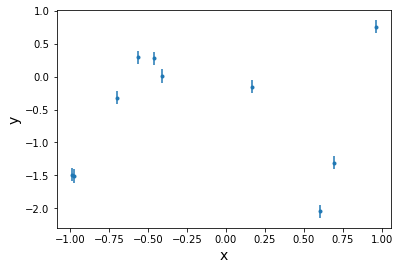

In [30]:
n_points=10
y_complex = np.zeros(n_points)
y_complex_sigma = np.zeros(n_points)
sigma=0.1
for i in range(0,n_points):
    y_complex[i] = model_complex(x_complex[i],params)+random.gauss(0,sigma)
    y_complex_sigma[i] = sigma

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.errorbar(x_complex,y_complex,yerr=y_complex_sigma,linestyle='None',marker='.')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

We can use a [WhiteKernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html) with a constant noise specified by the error, to add an extra variance term to the kernel. In the scikit-learn package however, this is easily spcified using the *alpha* parameter.

In [31]:
kernel = kernels.RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))

gp = GaussianProcessRegressor(kernel=kernel,alpha=y_complex_sigma**2)

xprime = np.atleast_2d(x_complex).T
yprime = np.atleast_2d(y_complex).T
gp.fit(xprime, yprime)
xplot_prime = np.atleast_2d(x_out_complex).T
y_pred, sigma_2 = gp.predict(x_out_complex[:, np.newaxis], return_std=True)

y_pred = y_pred.flatten()

Once again we can plot the outcome

200 200 200 200


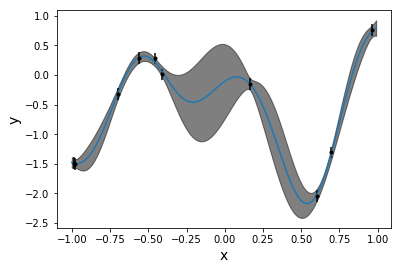

In [32]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)
x_out_complex=np.arange(-1,1,0.01)

y_out_complex=np.zeros(len(x_out_complex))
for i in range(0,len(x_out_complex)):
    y_out_complex[i]=model_complex(x_out_complex[i],params)
    
y_pred, sigma_2 = gp.predict(x_out_complex[:, np.newaxis], return_std=True)
print(len(x_out_complex), len(sigma_2), len(y_out_complex), len(y_pred))
y_pred = y_pred.flatten()
h0 = plt.errorbar(x_complex,y_complex,yerr=y_complex_sigma,linestyle='None',marker='.',color='black')
h1 = plt.plot(x_out_complex,y_pred,label='gaussian process')
plt.fill_between(x_out_complex, y_pred - sigma_2, y_pred + sigma_2,alpha=0.5, color='k')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

As you can see, this widens the prediction region around the data points, bringing it in line with the variance of the data. 

### Kernel Regression

Another non-linear regression method, that uses a smoothing of the nearest points, to estaimte $y$ at a new point $x$. The Nadaraya–Watson kernel regression approach is described as

\begin{equation}
\widehat{y}_h(x)=\frac{\sum_{i=1}^N K_h(x-x_i)y_i}{\sum_{i=1}^N K_h(x-x_i)}
\end{equation}
where $K$ is a kernel with a bandwidth $h$. The denominator is a weighting term with sum 1.

Here we apply [Kernel-Ridge Regression](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge) to our data, but using the same kernel (RBF) as we were in the GPR case.

In [33]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.model_selection import GridSearchCV
# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [kernels.RBF(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)

kr.fit(xprime, yprime)


GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': [RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.01), RBF(length_scale=0.0278), RBF(length_...(length_scale=100), RBF(length_scale=100), RBF(length_scale=100)], 'alpha': [1.0, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Now we make some predictions for the same range as we did for the GPR case.

In [34]:
y_krr = kr.predict(x_out_complex[:, np.newaxis])

Finally we plot these predictions against the GPR prediction and the data we have.

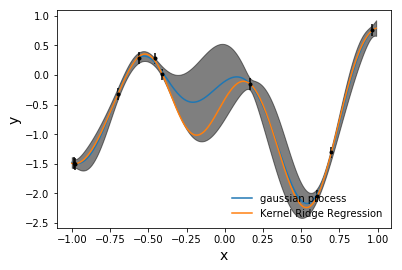

In [35]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)
h0 = plt.errorbar(x_complex,y_complex,yerr=y_complex_sigma,linestyle='None',marker='.',color='black')
h1 = plt.plot(x_out_complex,y_pred,label='gaussian process')
h2 = plt.plot(x_out_complex,y_krr,label='Kernel Ridge Regression')
plt.fill_between(x_out_complex, y_pred - sigma_2, y_pred + sigma_2,alpha=0.5, color='k')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=4)
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

We see, for a consistent choice of kernel, the predictions made by KRR and GPR are very close in the range given by the data, but diverge outside of that range.